In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
from sklearn.preprocessing import LabelEncoder
!pip install scikit-learn==1.0.2

In [2]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/e-nose for beef quality monitoring dataset.csv')

# Display basic dataset information
print("Dataset Overview:\n", data.info())
print("\nFirst 5 Rows:\n", data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4553 entries, 0 to 4552
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   minute       4553 non-null   int64  
 1   class        4553 non-null   object 
 2   TVC          4553 non-null   float64
 3   MQ135        4553 non-null   float64
 4   MQ136        4553 non-null   float64
 5   MQ2          4553 non-null   float64
 6   MQ3          4553 non-null   float64
 7   MQ4          4553 non-null   float64
 8   MQ5          4553 non-null   float64
 9   MQ6          4553 non-null   float64
 10  MQ7          4553 non-null   float64
 11  MQ8          4553 non-null   float64
 12  MQ9          4553 non-null   float64
 13  Humidity     4553 non-null   float64
 14  Temperature  4553 non-null   float64
dtypes: float64(13), int64(1), object(1)
memory usage: 533.7+ KB
Dataset Overview:
 None

First 5 Rows:
    minute  class       TVC  MQ135  MQ136    MQ2    MQ3    MQ4    MQ5   MQ6

In [3]:
# Check for missing values
if data.isnull().sum().sum() > 0:
    print("\nMissing Values Detected! Filling missing values with median...")
    data.fillna(data.median(), inplace=True)
    print("Missing Values Filled.")
else:
    print("\nNo Missing Values Found.")


No Missing Values Found.


In [4]:
# Separate features and target
X = data.drop(columns=['minute','class','MQ136','MQ5','MQ3','MQ4','MQ8'])
y = data['class']

In [5]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
# Create a LabelEncoder object
le = LabelEncoder()

# Fit the encoder to the target variable and transform it
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test) # Transform y_test using the same encoder
xgb_model = XGBClassifier(use_label_encoder=True, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [14:37:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [8]:
y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       136
           1       1.00      1.00      1.00       775

    accuracy                           1.00       911
   macro avg       1.00      1.00      1.00       911
weighted avg       1.00      1.00      1.00       911



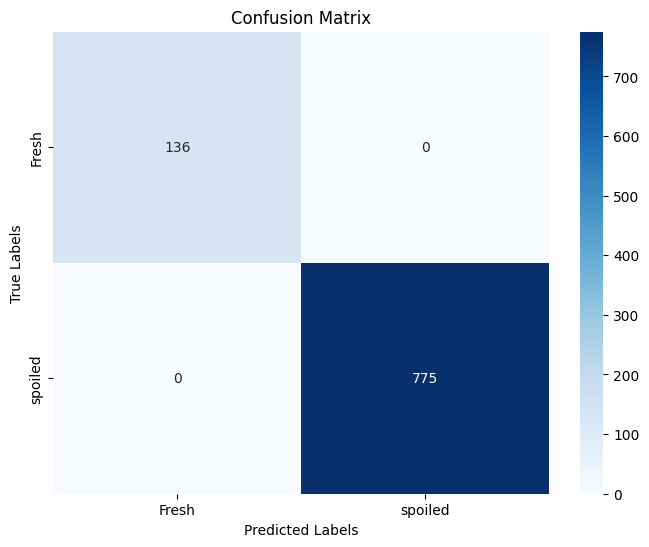

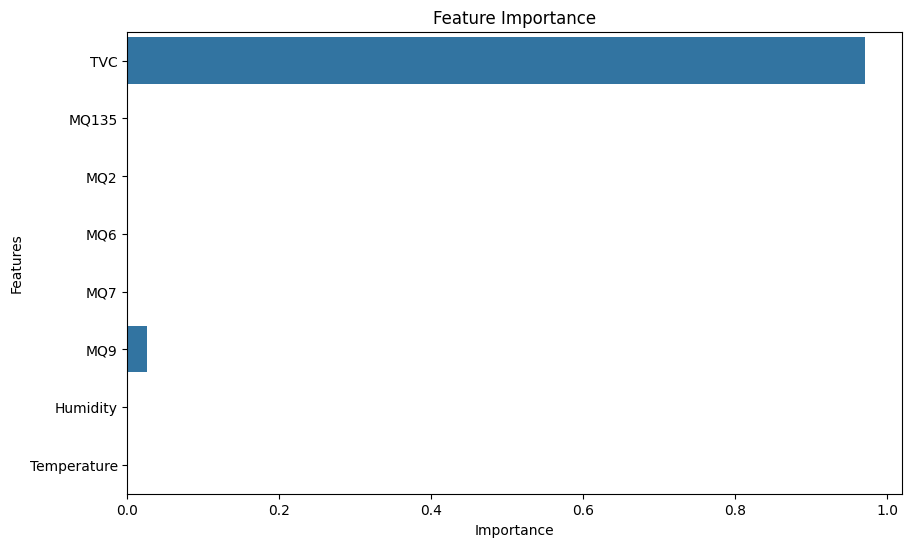

Model Accuracy: 1.00

Classification Report:
               precision    recall  f1-score   support

       Fresh       1.00      1.00      1.00       136
     spoiled       1.00      1.00      1.00       775

    accuracy                           1.00       911
   macro avg       1.00      1.00      1.00       911
weighted avg       1.00      1.00      1.00       911



In [9]:

# Step 1: Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_xgb)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Step 2: Feature Importance (For tree-based models)
feature_importances = xgb_model.feature_importances_
features = X.columns

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=features)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# Step 3: Accuracy and Classification Report
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"Model Accuracy: {accuracy:.2f}")
target_names = [str(c) for c in le.classes_]
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb, target_names=target_names))


In [10]:
import os
save_dir = r'/content/drive/MyDrive/Colab Notebooks'
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist
file_path = os.path.join(save_dir, 'XGBoost_model.pkl')

# Save the trained model
joblib.dump(xgb_model, file_path)
print(f"\nModel saved at: {file_path}")


Model saved at: /content/drive/MyDrive/Colab Notebooks/XGBoost_model.pkl
